In [1]:
# Imports
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import numpy as np
from scipy.stats import zscore
import matplotlib as mpl
from matplotlib import pyplot as plt

import torch
from torch import nn, optim
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [3]:
# @title Plotting Functions

def show_stimulus(img, ax=None, show=False):
  """Visualize a stimulus"""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img, cmap=mpl.cm.binary)
  ax.set_aspect('auto')
  ax.set_xticks([])
  ax.set_yticks([])
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  if show:
    plt.show()


def plot_corr_matrix(rdm, ax=None, show=False):
  """Plot dissimilarity matrix

  Args:
    rdm (numpy array): n_stimuli x n_stimuli representational dissimilarity
      matrix
    ax (matplotlib axes): axes onto which to plot

  Returns:
    nothing

  """
  if ax is None:
    ax = plt.gca()
  image = ax.imshow(rdm, vmin=0.0, vmax=2.0)
  ax.set_xticks([])
  ax.set_yticks([])
  cbar = plt.colorbar(image, ax=ax, label='dissimilarity')
  if show:
    plt.show()


def plot_multiple_rdm(rdm_dict):
  """Draw multiple subplots for each RDM in rdm_dict."""
  fig, axs = plt.subplots(1, len(rdm_dict),
                          figsize=(4 * len(rdm_dict), 3.5))

  # Compute RDM's for each set of responses and plot
  for i, (label, rdm) in enumerate(rdm_dict.items()):

    image = plot_corr_matrix(rdm, axs[i])
    axs[i].set_title(label)
  plt.show()


def plot_rdm_rdm_correlations(rdm_sim):
  """Draw a bar plot showing between-RDM correlations."""
  f, ax = plt.subplots()
  ax.bar(rdm_sim.keys(), rdm_sim.values())
  ax.set_xlabel('Deep network model layer')
  ax.set_ylabel('Correlation of model layer RDM\nwith mouse V1 RDM')
  plt.show()


def plot_rdm_rows(ori_list, rdm_dict, rdm_oris):
  """Plot the dissimilarity of response to each stimulus with response to one
  specific stimulus

  Args:
    ori_list (list of float): plot dissimilarity with response to stimulus with
      orientations closest to each value in this list
    rdm_dict (dict): RDM's from which to extract dissimilarities
    rdm_oris (np.ndarray): orientations corresponding to each row/column of RDMs
    in rdm_dict

  """
  n_col = len(ori_list)
  f, axs = plt.subplots(1, n_col, figsize=(4 * n_col, 4), sharey=True)

  # Get index of orientation closest to ori_plot
  for ax, ori_plot in zip(axs, ori_list):
    iori = np.argmin(np.abs(rdm_oris - ori_plot))

    # Plot dissimilarity curves in each RDM
    for label, rdm in rdm_dict.items():
      ax.plot(rdm_oris, rdm[iori, :], label=label)

    # Draw vertical line at stimulus we are plotting dissimilarity w.r.t.
    ax.axvline(rdm_oris[iori], color=".7", zorder=-1)

    # Label axes
    ax.set_title(
        f'Dissimilarity with response\nto {ori_plot: .0f}$^o$ stimulus')
    ax.set_xlabel('Stimulus orientation ($^o$)')

  axs[0].set_ylabel('Dissimilarity')
  axs[-1].legend(loc="upper left", bbox_to_anchor=(1, 1))
  plt.tight_layout()
  plt.show()

In [4]:
# @title Helper Functions

def load_data(data_name, bin_width=1):
  """Load mouse V1 data from Stringer et al. (2019)

  Data from study reported in this preprint:
  https://www.biorxiv.org/content/10.1101/679324v2.abstract

  These data comprise time-averaged responses of ~20,000 neurons
  to ~4,000 stimulus gratings of different orientations, recorded
  through Calcium imaginge. The responses have been normalized by
  spontaneous levels of activity and then z-scored over stimuli, so
  expect negative numbers. They have also been binned and averaged
  to each degree of orientation.

  This function returns the relevant data (neural responses and
  stimulus orientations) in a torch.Tensor of data type torch.float32
  in order to match the default data type for nn.Parameters in
  Google Colab.

  This function will actually average responses to stimuli with orientations
  falling within bins specified by the bin_width argument. This helps
  produce individual neural "responses" with smoother and more
  interpretable tuning curves.

  Args:
    bin_width (float): size of stimulus bins over which to average neural
      responses

  Returns:
    resp (torch.Tensor): n_stimuli x n_neurons matrix of neural responses,
        each row contains the responses of each neuron to a given stimulus.
        As mentioned above, neural "response" is actually an average over
        responses to stimuli with similar angles falling within specified bins.
    stimuli: (torch.Tensor): n_stimuli x 1 column vector with orientation
        of each stimulus, in degrees. This is actually the mean orientation
        of all stimuli in each bin.

  """
  with np.load(data_name) as dobj:
    data = dict(**dobj)
  resp = data['resp']
  stimuli = data['stimuli']

  if bin_width > 1:
    # Bin neural responses and stimuli
    bins = np.digitize(stimuli, np.arange(0, 360 + bin_width, bin_width))
    stimuli_binned = np.array([stimuli[bins == i].mean()
                              for i in np.unique(bins)])
    resp_binned = np.array([resp[bins == i, :].mean(0)
                           for i in np.unique(bins)])
  else:
    resp_binned = resp
    stimuli_binned = stimuli

  # only use stimuli <= 180
  resp_binned = resp_binned[stimuli_binned <= 180]
  stimuli_binned = stimuli_binned[stimuli_binned <= 180]

  stimuli_binned -= 90  # 0 means vertical, -ve means tilted left, +ve means tilted right

  # Return as torch.Tensor
  resp_tensor = torch.tensor(resp_binned, dtype=torch.float32)
  stimuli_tensor = torch.tensor(stimuli_binned, dtype=torch.float32).unsqueeze(
      1)  # add singleton dimension to make a column vector

  return resp_tensor, stimuli_tensor


def grating(angle, sf=1 / 28, res=0.1, patch=False):
  """Generate oriented grating stimulus

  Args:
    angle (float): orientation of grating (angle from vertical), in degrees
    sf (float): controls spatial frequency of the grating
    res (float): resolution of image. Smaller values will make the image
      smaller in terms of pixels. res=1.0 corresponds to 640 x 480 pixels.
    patch (boolean): set to True to make the grating a localized
      patch on the left side of the image. If False, then the
      grating occupies the full image.

  Returns:
    torch.Tensor: (res * 480) x (res * 640) pixel oriented grating image

  """

  angle = np.deg2rad(angle)  # transform to radians

  wpix, hpix = 640, 480  # width and height of image in pixels for res=1.0

  xx, yy = np.meshgrid(sf * np.arange(0, wpix * res) / res,
                       sf * np.arange(0, hpix * res) / res)

  if patch:
    # phase shift to make it better fit within patch
    gratings = np.cos(xx * np.cos(angle + .1) + yy * np.sin(angle + .1))
    gratings[gratings < 0] = 0
    gratings[gratings > 0] = 1
    xcent = gratings.shape[1] * .75
    ycent = gratings.shape[0] / 2
    xxc, yyc = np.meshgrid(
        np.arange(0, gratings.shape[1]), np.arange(0, gratings.shape[0]))
    icirc = ((xxc - xcent) ** 2 + (yyc - ycent)
             ** 2) ** 0.5 < wpix / 3 / 2 * res
    gratings[~icirc] = 0.5

  else:
    gratings = np.cos(xx * np.cos(angle) + yy * np.sin(angle))
    gratings[gratings < 0] = 0
    gratings[gratings > 0] = 1

  # Return torch tensor
  return torch.tensor(gratings, dtype=torch.float32)


def filters(out_channels=6, K=7):
  """ make example filters, some center-surround and gabors
  Returns:
      filters: out_channels x K x K
  """
  grid = np.linspace(-K/2, K/2, K).astype(np.float32)
  xx, yy = np.meshgrid(grid, grid, indexing='ij')

  # create center-surround filters
  sigma = 1.1
  gaussian = np.exp(-(xx**2 + yy**2)**0.5/(2*sigma**2))
  wide_gaussian = np.exp(-(xx**2 + yy**2)**0.5/(2*(sigma*2)**2))
  center_surround = gaussian - 0.5 * wide_gaussian

  # create gabor filters
  thetas = np.linspace(0, 180, out_channels-2+1)[:-1] * np.pi/180
  gabors = np.zeros((len(thetas), K, K), np.float32)
  lam = 10
  phi = np.pi/2
  gaussian = np.exp(-(xx**2 + yy**2)**0.5/(2*(sigma*0.4)**2))
  for i, theta in enumerate(thetas):
    x = xx*np.cos(theta) + yy*np.sin(theta)
    gabors[i] = gaussian * np.cos(2*np.pi*x/lam + phi)

  filters = np.concatenate((center_surround[np.newaxis, :, :],
                            -1*center_surround[np.newaxis, :, :],
                            gabors),
                           axis=0)
  filters /= np.abs(filters).max(axis=(1, 2))[:, np.newaxis, np.newaxis]
  # convert to torch
  filters = torch.from_numpy(filters)
  # add channel axis
  filters = filters.unsqueeze(1)

  return filters


class CNN(nn.Module):
  """Deep convolutional network with one convolutional + pooling layer followed
  by one fully connected layer

  Args:
    h_in (int): height of input image, in pixels (i.e. number of rows)
    w_in (int): width of input image, in pixels (i.e. number of columns)

  Attributes:
    conv (nn.Conv2d): filter weights of convolutional layer
    pool (nn.MaxPool2d): max pooling layer
    dims (tuple of ints): dimensions of output from pool layer
    fc (nn.Linear): weights and biases of fully connected layer
    out (nn.Linear): weights and biases of output layer

  """

  def __init__(self, h_in, w_in):
    super().__init__()
    C_in = 1  # input stimuli have only 1 input channel
    # number of output channels (i.e. of convolutional kernels to convolve the input with)
    C_out = 6
    K = 7  # size of each convolutional kernel
    Kpool = 8  # size of patches over which to pool
    # add padding to ensure that each channel has same dimensionality as input
    self.conv = nn.Conv2d(C_in, C_out, kernel_size=K, padding=K//2)
    self.pool = nn.MaxPool2d(Kpool)
    # dimensions of pool layer output
    self.dims = (C_out, h_in // Kpool, w_in // Kpool)
    # flattened pool output --> 10D representation
    self.fc = nn.Linear(np.prod(self.dims), 10)
    self.out = nn.Linear(10, 1)  # 10D representation --> scalar
    self.conv.weight = nn.Parameter(filters(C_out, K))
    self.conv.bias = nn.Parameter(torch.zeros((C_out,), dtype=torch.float32))

  def forward(self, x):
    """Classify grating stimulus as tilted right or left

    Args:
      x (torch.Tensor): p x 48 x 64 tensor with pixel grayscale values for
          each of p stimulus images.

    Returns:
      torch.Tensor: p x 1 tensor with network outputs for each input provided
          in x. Each output should be interpreted as the probability of the
          corresponding stimulus being tilted right.

    """
    x = x.unsqueeze(
        1)  # p x 1 x 48 x 64, add a singleton dimension for the single stimulus channel
    x = torch.relu(self.conv(x))  # output of convolutional layer
    x = self.pool(x)  # output of pooling layer
    # flatten pooling layer outputs into a vector
    x = x.view(-1, np.prod(self.dims))
    x = torch.relu(self.fc(x))  # output of fully connected layer
    x = torch.sigmoid(self.out(x))  # network output
    return x


def train(net, train_data, train_labels,
          n_epochs=25, learning_rate=0.0005,
          batch_size=100, momentum=.99):
  """Run stochastic gradient descent on binary cross-entropy loss for a given
  deep network (cf. appendix for details)

  Args:
    net (nn.Module): deep network whose parameters to optimize with SGD
    train_data (torch.Tensor): n_train x h x w tensor with stimulus gratings
    train_labels (torch.Tensor): n_train x 1 tensor with true tilt of each
      stimulus grating in train_data, i.e. 1. for right, 0. for left
    n_epochs (int): number of times to run SGD through whole training data set
    batch_size (int): number of training data samples in each mini-batch
    learning_rate (float): learning rate to use for SGD updates
    momentum (float): momentum parameter for SGD updates

  """

  # Initialize binary cross-entropy loss function
  loss_fn = nn.BCELoss()

  # Initialize SGD optimizer with momentum
  optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

  # Placeholder to save loss at each iteration
  track_loss = []

  # Loop over epochs
  for i in range(n_epochs):

    # Split up training data into random non-overlapping mini-batches
    # random ordering of training data
    ishuffle = torch.randperm(train_data.shape[0])
    # split train_data into minibatches
    minibatch_data = torch.split(train_data[ishuffle], batch_size)
    # split train_labels into minibatches
    minibatch_labels = torch.split(train_labels[ishuffle], batch_size)

    # Loop over mini-batches
    for stimuli, tilt in zip(minibatch_data, minibatch_labels):

      # Evaluate loss and update network weights
      out = net(stimuli)  # predicted probability of tilt right
      loss = loss_fn(out, tilt)  # evaluate loss
      optimizer.zero_grad()  # clear gradients
      loss.backward()  # compute gradients
      optimizer.step()  # update weights

      # Keep track of loss at each iteration
      track_loss.append(loss.item())

    # Track progress
    if (i + 1) % (n_epochs // 5) == 0:
      print(f'epoch {i + 1} | loss on last mini-batch: {loss.item(): .2e}')

  print('training done!')


def get_hidden_activity(net, stimuli, layer_labels):
  """Retrieve internal representations of network

  Args:
    net (nn.Module): deep network
    stimuli (torch.Tensor): p x 48 x 64 tensor with stimuli for which to
      compute and retrieve internal representations
    layer_labels (list): list of strings with labels of each layer for which
      to return its internal representations

  Returns:
    dict: internal representations at each layer of the network, in
      numpy arrays. The keys of this dict are the strings in layer_labels.

  """

  # Placeholder
  hidden_activity = {}

  # Attach 'hooks' to each layer of the network to store hidden
  # representations in hidden_activity
  def hook(module, input, output):
    module_label = list(net._modules.keys())[np.argwhere(
        [module == m for m in net._modules.values()])[0, 0]]
    if module_label in layer_labels:  # ignore output layer
      hidden_activity[module_label] = output.view(
          stimuli.shape[0], -1).detach().numpy()
  hooks = [layer.register_forward_hook(hook) for layer in net.children()]

  # Run stimuli through the network
  pred = net(stimuli)

  # Remove the hooks
  [h.remove() for h in hooks]

  return hidden_activity

In [5]:
# @title Data retrieval and loading
import os
import hashlib
import requests

fname = "W3D4_stringer_oribinned1.npz"
url = "https://osf.io/683xc/download"
expected_md5 = "436599dfd8ebe6019f066c38aed20580"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    elif hashlib.md5(r.content).hexdigest() != expected_md5:
      print("!!! Data download appears corrupted !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

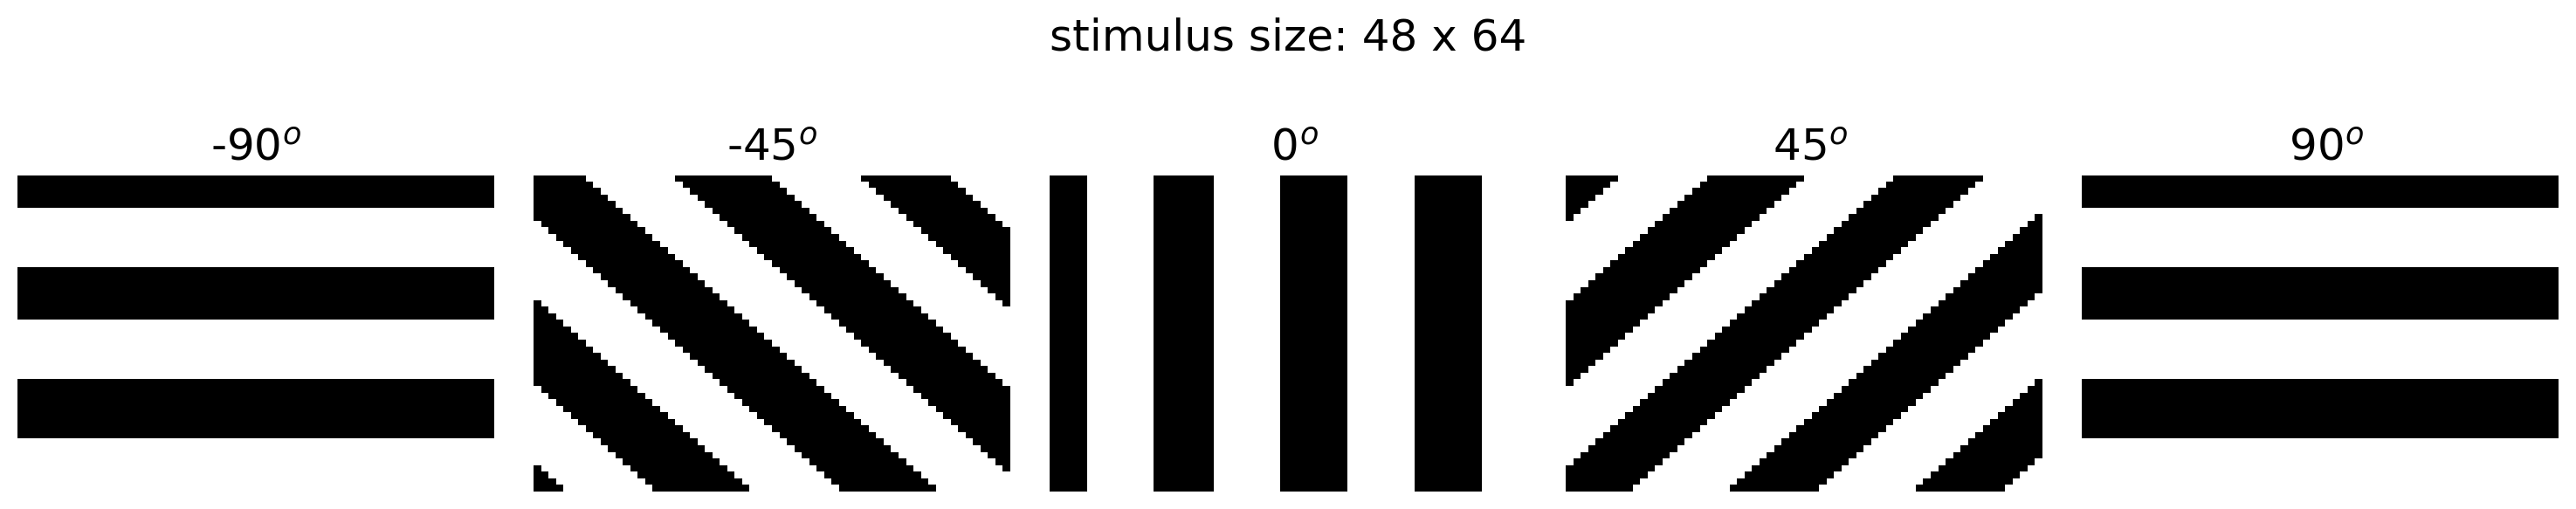

In [6]:
# @markdown Execute this cell to plot example stimuli

orientations = np.linspace(-90, 90, 5)

h_ = 3
n_col = len(orientations)
h, w = grating(0).shape  # height and width of stimulus
fig, axs = plt.subplots(1, n_col, figsize=(h_ * n_col, h_))

for i, ori in enumerate(orientations):
  stimulus = grating(ori)
  axs[i].set_title(f'{ori: .0f}$^o$')
  show_stimulus(stimulus, axs[i])
fig.suptitle(f'stimulus size: {h} x {w}')
plt.tight_layout()
plt.show()

In [7]:
help(train)

Help on function train in module __main__:

train(net, train_data, train_labels, n_epochs=25, learning_rate=0.0005, batch_size=100, momentum=0.99)
    Run stochastic gradient descent on binary cross-entropy loss for a given
    deep network (cf. appendix for details)

    Args:
      net (nn.Module): deep network whose parameters to optimize with SGD
      train_data (torch.Tensor): n_train x h x w tensor with stimulus gratings
      train_labels (torch.Tensor): n_train x 1 tensor with true tilt of each
        stimulus grating in train_data, i.e. 1. for right, 0. for left
      n_epochs (int): number of times to run SGD through whole training data set
      batch_size (int): number of training data samples in each mini-batch
      learning_rate (float): learning rate to use for SGD updates
      momentum (float): momentum parameter for SGD updates



In [8]:
# Set random seeds for reproducibility
np.random.seed(12)
torch.manual_seed(12)

# Initialize CNN model
net = CNN(h, w)

# Build training set to train it on
n_train = 1000  # size of training set

# sample n_train random orientations between -90 and +90 degrees
ori = (np.random.rand(n_train) - 0.5) * 180

# build orientated grating stimuli
stimuli = torch.stack([grating(i) for i in ori])

# stimulus tilt: 1. if tilted right, 0. if tilted left, as a column vector
tilt = torch.tensor(ori > 0).type(torch.float).unsqueeze(-1)

# Train model
train(net, stimuli, tilt)

epoch 5 | loss on last mini-batch:  4.10e-01
epoch 10 | loss on last mini-batch:  5.17e-02
epoch 15 | loss on last mini-batch:  1.32e-02
epoch 20 | loss on last mini-batch:  2.29e-03
epoch 25 | loss on last mini-batch:  8.08e-05
training done!


In [9]:
# Load mouse V1 data
resp_v1, ori = load_data(fname)

# Extract model internal representations of each stimulus in the V1 data
# construct grating stimuli for each orientation presented in the V1 data
stimuli = torch.stack([grating(a.item()) for a in ori])
layer_labels = ['pool', 'fc']
resp_model = get_hidden_activity(net, stimuli, layer_labels)

# Aggregate all responses into one dict
resp_dict = {}
resp_dict['V1 data'] = resp_v1
for k, v in resp_model.items():
  label = f"model\n'{k}' layer"
  resp_dict[label] = v

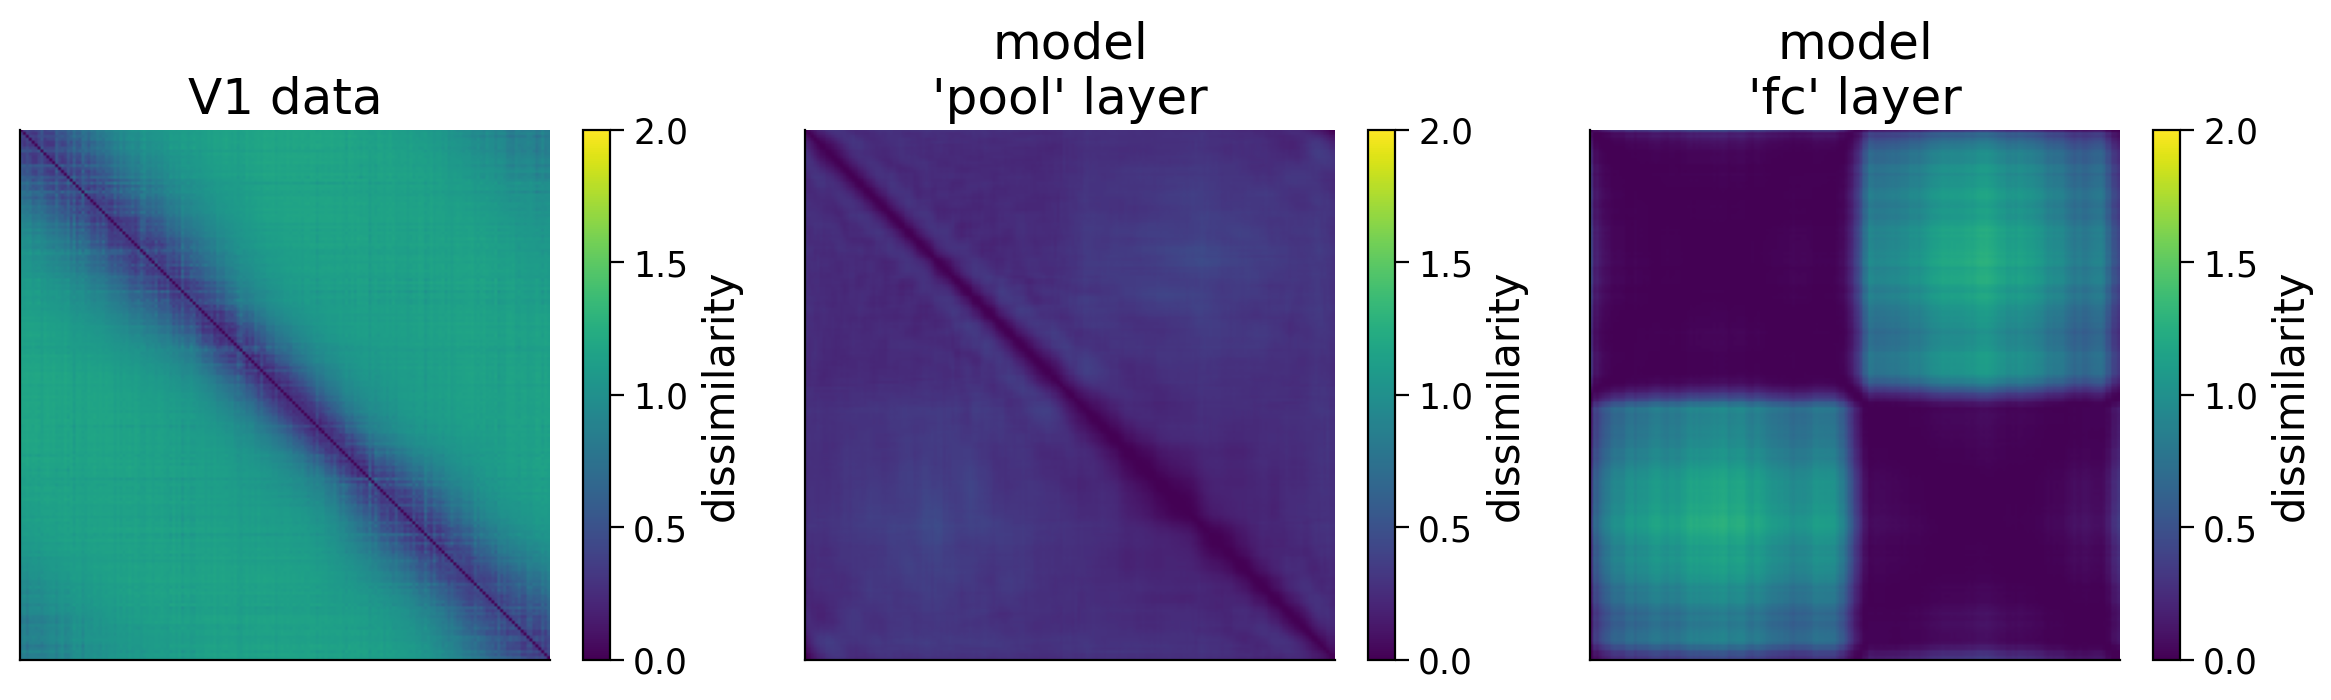

In [10]:
def RDM(resp):
  """Compute the representational dissimilarity matrix (RDM)

  Args:
    resp (ndarray): S x N matrix with population responses to
      each stimulus in each row

  Returns:
    ndarray: S x S representational dissimilarity matrix
  """
  #########################################################
  # TO DO for students: compute representational dissimilarity matrix
  # Fill out function and remove
  #raise NotImplementedError("Student exercise: complete function RDM")
  #########################################################

  # z-score responses to each stimulus
  zresp = zscore(resp, axis=1)

  # Compute RDM
  RDM = 1-1/zresp.shape[1]*zresp@zresp.T

  return RDM


# Compute RDMs for each layer
rdm_dict = {label: RDM(resp) for label, resp in resp_dict.items()}

# Plot RDMs
plot_multiple_rdm(rdm_dict)

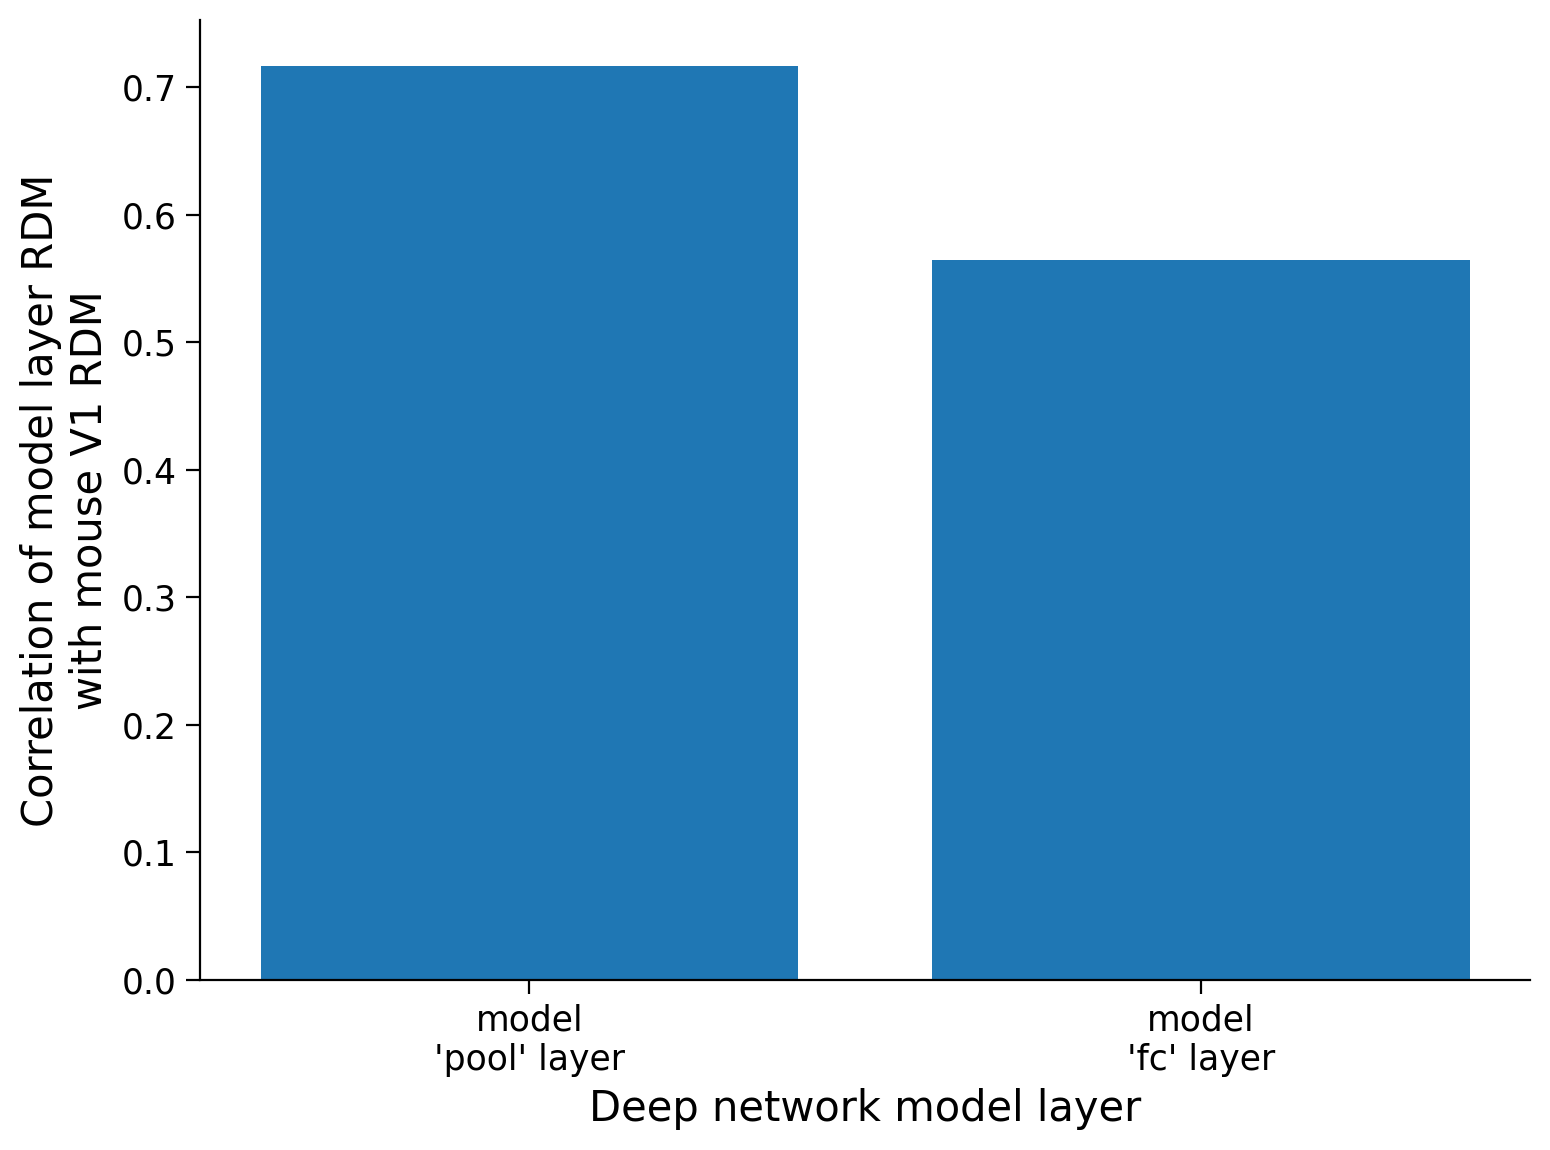

In [11]:
def correlate_rdms(rdm1, rdm2):
  """Correlate off-diagonal elements of two RDM's

  Args:
    rdm1 (np.ndarray): S x S representational dissimilarity matrix
    rdm2 (np.ndarray): S x S representational dissimilarity matrix to
      correlate with rdm1

  Returns:
    float: correlation coefficient between the off-diagonal elements
      of rdm1 and rdm2

  """

  # Extract off-diagonal elements of each RDM
  # indices of off-diagonal elements
  ioffdiag = np.triu_indices(rdm1.shape[0], k=1)
  rdm1_offdiag = rdm1[ioffdiag]
  rdm2_offdiag = rdm2[ioffdiag]

  #########################################################
  # TO DO for students: compute correlation coefficient
  # Fill out function and remove
  #raise NotImplementedError("Student exercise: complete correlate rdms")
  #########################################################
  corr_coef = np.corrcoef(rdm1_offdiag, rdm2_offdiag)[0, 1]

  return corr_coef


# Split RDMs into V1 responses and model responses
rdm_model = rdm_dict.copy()
rdm_v1 = rdm_model.pop('V1 data')

# Correlate off-diagonal terms of dissimilarity matrices
rdm_sim = {label: correlate_rdms(rdm_v1, rdm)
           for label, rdm in rdm_model.items()}

# Visualize
plot_rdm_rdm_correlations(rdm_sim)

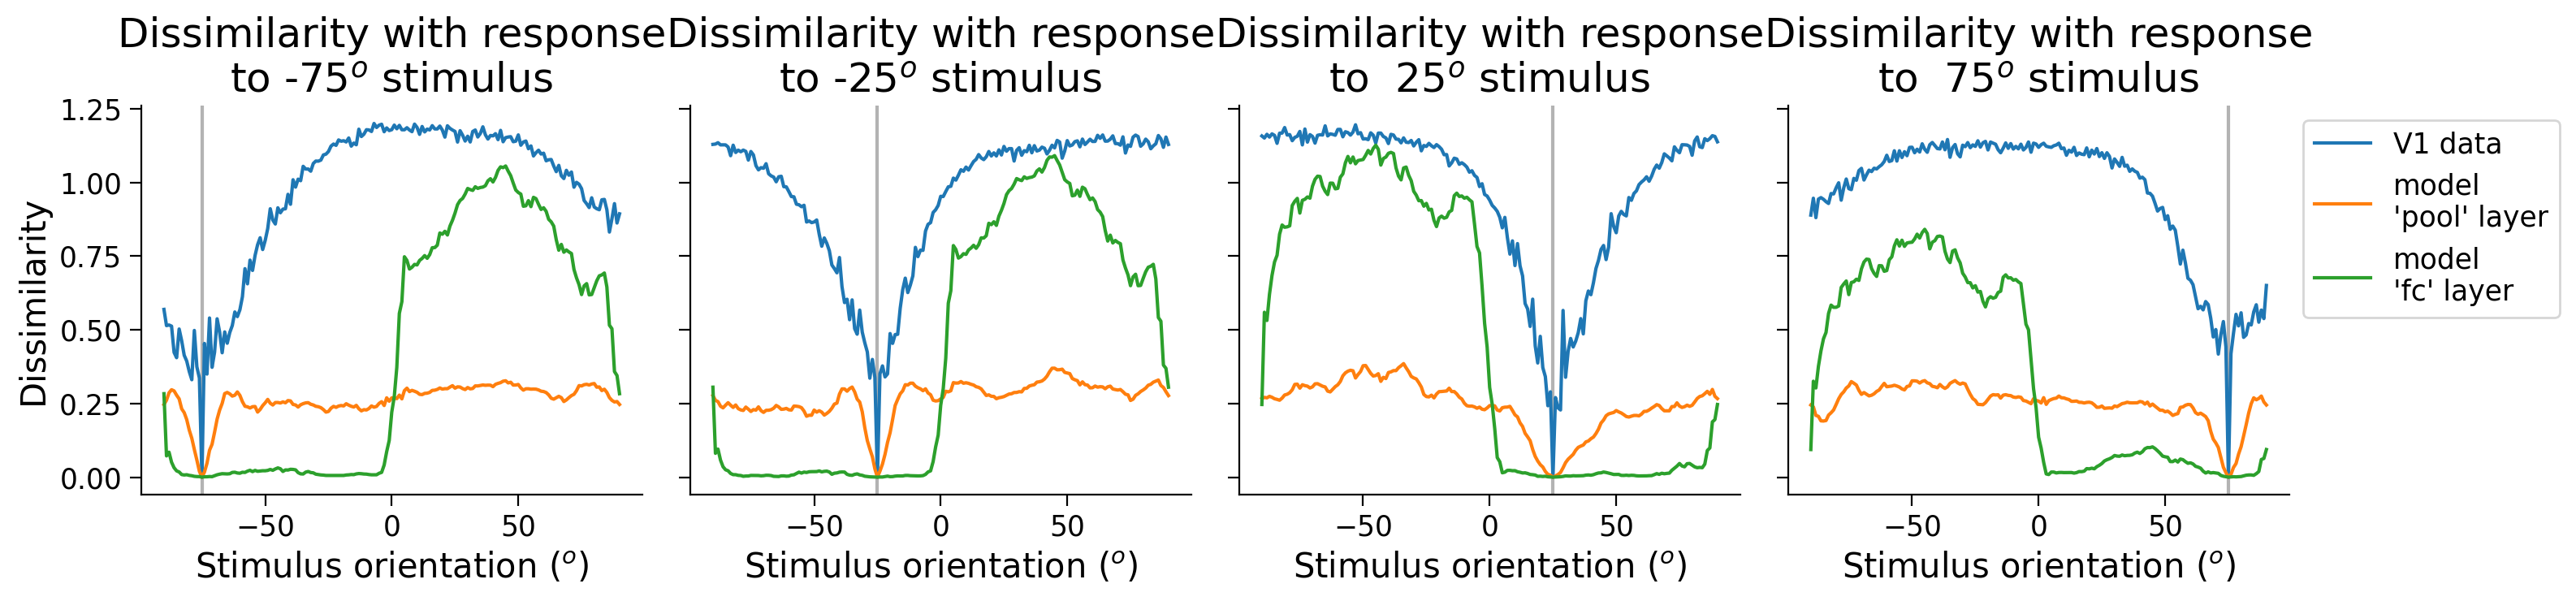

In [12]:
ori_list = [-75, -25, 25, 75]
plot_rdm_rows(ori_list, rdm_dict, ori.numpy())

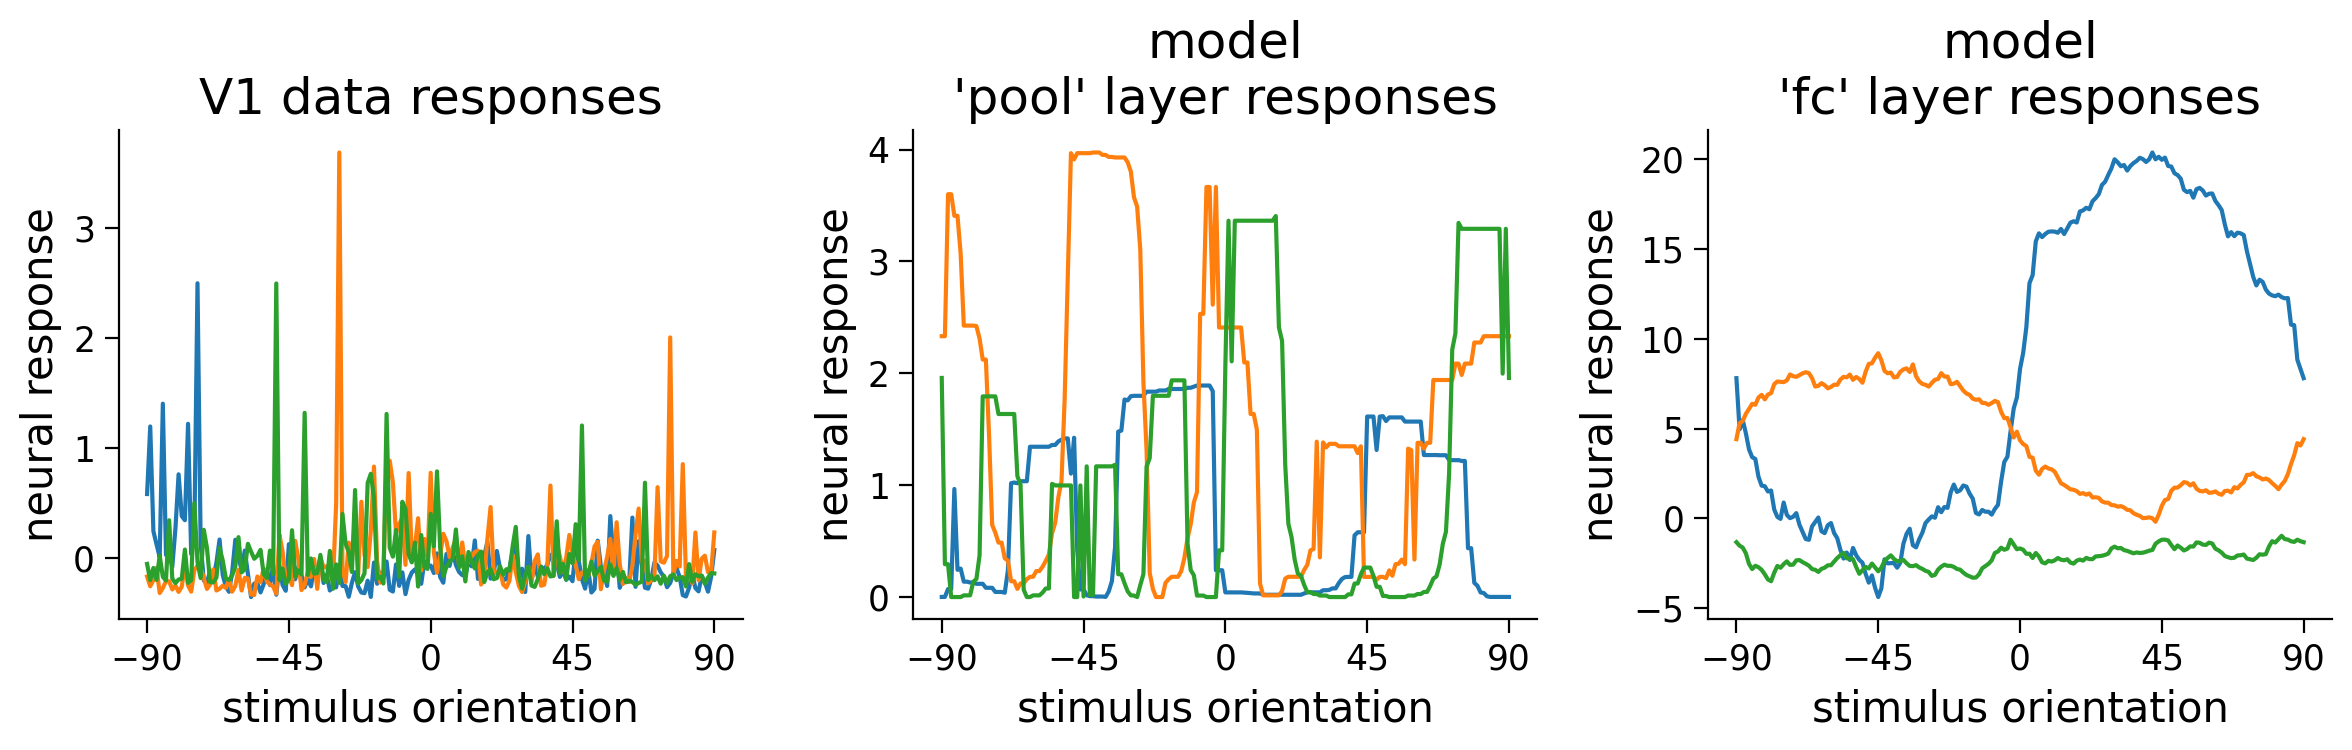

In [13]:
# @markdown Execute this cell to visualize tuning curves

fig, axs = plt.subplots(1, len(resp_dict), figsize=(len(resp_dict) * 4, 4))

for i, (label, resp) in enumerate(resp_dict.items()):

  ax = axs[i]
  ax.set_title(f'{label} responses')

  # Pick three random neurons whose tuning curves to plot
  ineurons = np.random.choice(resp.shape[1], 3, replace=False)

  # Plot tuning curves of ineurons
  ax.plot(ori, resp[:, ineurons])

  ax.set_xticks(np.linspace(-90, 90, 5))
  ax.set_xlabel('stimulus orientation')
  ax.set_ylabel('neural response')

plt.tight_layout()
plt.show()

Running TSNE on V1 data: 181 samples, perplexity=30
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 181 samples in 0.001s...
[t-SNE] Computed neighbors for 181 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 181 / 181
[t-SNE] Mean sigma: 33.066785
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.490696
[t-SNE] KL divergence after 300 iterations: 0.101139
Running TSNE on model
'pool' layer: 181 samples, perplexity=30
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 181 samples in 0.001s...
[t-SNE] Computed neighbors for 181 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 181 / 181
[t-SNE] Mean sigma: 10.268498
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.308369
[t-SNE] KL divergence after 300 iterations: 0.200900
Running TSNE on model
'fc' layer: 181 samples, perplexity=30
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 181 samples in 0.000s...
[t-SNE] Compu

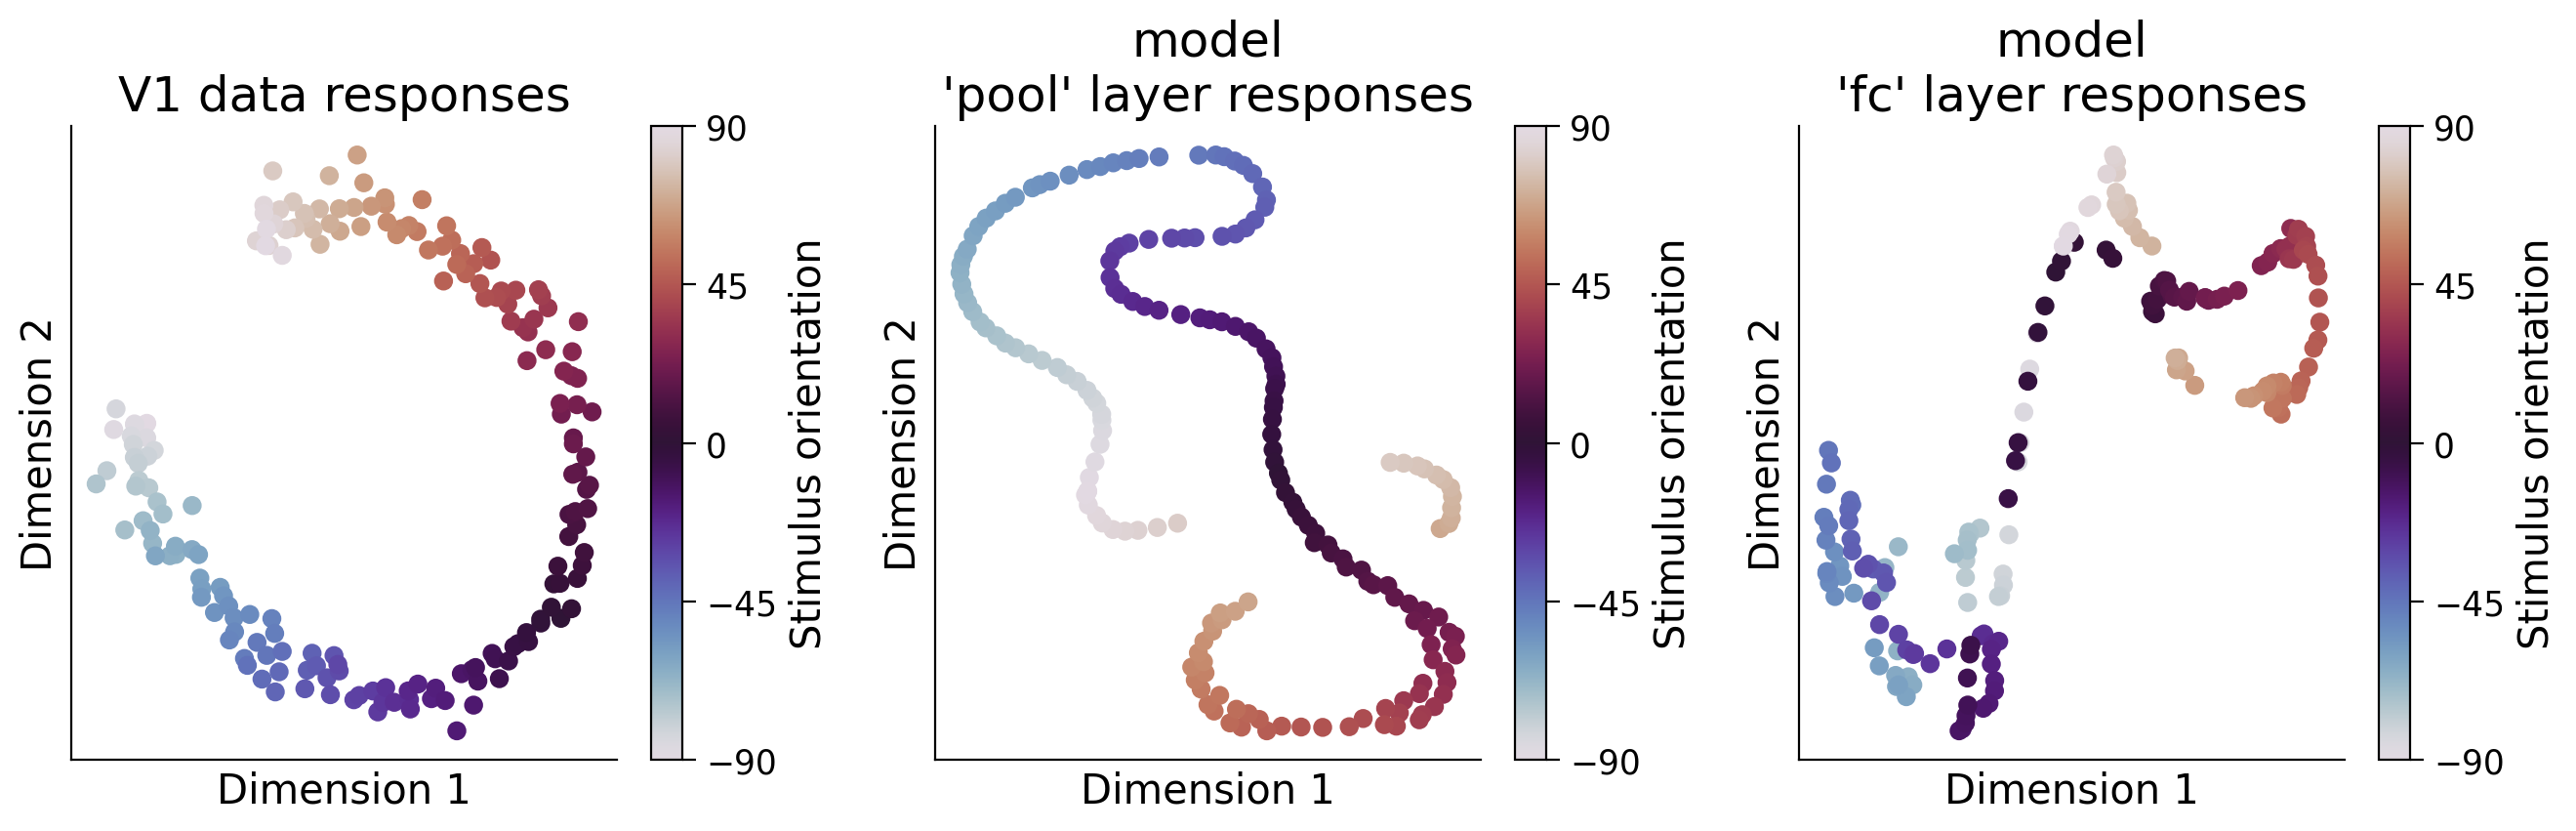

In [15]:
# @markdown Execute this cell to visualize low-d representations
import gc  # For explicit garbage collection

def plot_resp_lowd(resp_dict, max_samples=300, use_tsne=False):
  """Plot a low-dimensional representation of each dataset in resp_dict.
  
  Args:
    resp_dict: dictionary of response arrays
    max_samples: maximum number of samples to use for TSNE (to avoid memory issues)
    use_tsne: if False, use only PCA (faster, less memory-intensive). 
              TSNE is very memory-intensive and may crash the kernel.
  """
  # Clear any existing figures to free memory
  plt.close('all')
  gc.collect()  # Initial cleanup
  
  n_col = len(resp_dict)
  fig, axs = plt.subplots(1, n_col, figsize=(4.5 * len(resp_dict), 4.5))
  
  for i, (label, resp) in enumerate(resp_dict.items()):
    ax = axs[i]
    ax.set_title(f'{label} responses')

    try:
      # Convert resp to numpy array if it's a torch tensor
      if hasattr(resp, 'numpy'):
        resp = resp.numpy()
      elif hasattr(resp, 'detach'):
        resp = resp.detach().numpy()
      else:
        resp = np.array(resp)

      # Subsample if dataset is too large (TSNE is memory-intensive)
      n_samples = resp.shape[0]
      if n_samples > max_samples:
        indices = np.random.choice(n_samples, max_samples, replace=False)
        resp_subset = resp[indices]
        ori_subset = ori.numpy().flatten()[indices] if hasattr(ori, 'numpy') else np.array(ori).flatten()[indices]
      else:
        resp_subset = resp
        ori_subset = ori.numpy().flatten() if hasattr(ori, 'numpy') else np.array(ori).flatten()

      # Clean up original resp if we subsampled
      if n_samples > max_samples:
        del resp
        gc.collect()

      # First do PCA to reduce dimensionality
      n_pca_components = min(20, resp_subset.shape[1])
      resp_lowd = PCA(n_components=n_pca_components, random_state=0).fit_transform(resp_subset)
      
      # Clean up resp_subset after PCA
      del resp_subset
      gc.collect()

      # Then do tSNE to reduce dimensionality to 2 dimensions (if requested)
      if use_tsne:
        n_subset = resp_lowd.shape[0]
        # Perplexity must be between 5 and n_samples (sklearn will cap it)
        perplexity_val = min(30, max(5, min(n_subset - 1, n_subset // 4)))
        print(f"Running TSNE on {label}: {n_subset} samples, perplexity={perplexity_val}")
        try:
          tsne = TSNE(n_components=2, random_state=42, 
                           perplexity=perplexity_val,
                           method='barnes_hut',  # Much more memory-efficient than default
                           max_iter=300,  # Further reduced for notebook safety
                           angle=0.5,
                           n_jobs=1,verbose=1)
          resp_lowd = tsne.fit_transform(resp_lowd)  # Single-threaded to reduce memory
          gc.collect()  # Cleanup immediately after TSNE
        except (MemoryError, Exception) as e:
          print(f"TSNE failed for {label} ({e}), falling back to PCA")
          resp_lowd = resp_lowd[:, :2]  # Fallback to PCA
          gc.collect()
      else:
        # Just use first 2 PCA components
        n_subset = resp_lowd.shape[0]
        resp_lowd = resp_lowd[:, :2]
        print(f"Using PCA on {label}: {n_subset} samples")

      # Plot dimensionality-reduced population responses 'resp_lowd'
      # on 2D axes, with each point colored by stimulus orientation
      x, y = resp_lowd[:, 0], resp_lowd[:, 1]
      # Use ori_subset which was already created above (matching the subset)
      pts = ax.scatter(x, y, c=ori_subset, cmap='twilight', vmin=-90, vmax=90)
      fig.colorbar(pts, ax=ax, ticks=np.linspace(-90, 90, 5),
                   label='Stimulus orientation')

      ax.set_xlabel('Dimension 1')
      ax.set_ylabel('Dimension 2')
      ax.set_xticks([])
      ax.set_yticks([])
      
      # Clean up intermediate arrays after plotting
      del resp_lowd, x, y, ori_subset
      gc.collect()
      
    except Exception as e:
      print(f"Error processing {label}: {e}")
      ax.text(0.5, 0.5, f'Error: {str(e)[:50]}', 
              transform=ax.transAxes, ha='center', va='center')
      ax.set_xticks([])
      ax.set_yticks([])
  
  plt.tight_layout()
  plt.show()
  
  # Final cleanup
  gc.collect()


# Default uses PCA (safe and fast). TSNE is very memory-intensive and may crash.
# To try TSNE: plot_resp_lowd(resp_dict, max_samples=100, use_tsne=True)
# Note: TSNE will automatically fall back to PCA if it fails
plot_resp_lowd(resp_dict, max_samples=300, use_tsne=True)

In [ ]:
help(TSNE)

Help on class TSNE in module sklearn.manifold._t_sne:

class TSNE(sklearn.base.ClassNamePrefixFeaturesOutMixin, sklearn.base.TransformerMixin, sklearn.base.BaseEstimator)
 |  TSNE(n_components=2, *, perplexity=30.0, early_exaggeration=12.0, learning_rate='auto', max_iter=None, n_iter_without_progress=300, min_grad_norm=1e-07, metric='euclidean', metric_params=None, init='pca', verbose=0, random_state=None, method='barnes_hut', angle=0.5, n_jobs=None, n_iter='deprecated')
 |  
 |  T-distributed Stochastic Neighbor Embedding.
 |  
 |  t-SNE [1] is a tool to visualize high-dimensional data. It converts
 |  similarities between data points to joint probabilities and tries
 |  to minimize the Kullback-Leibler divergence between the joint
 |  probabilities of the low-dimensional embedding and the
 |  high-dimensional data. t-SNE has a cost function that is not convex,
 |  i.e. with different initializations we can get different results.
 |  
 |  It is highly recommended to use another dimens

In [ ]:
import sys
print(sys.executable)
!python --version

/Users/dom/anaconda3/bin/python
Python 3.11.10
